### dr inż. Mateusz Gorczyca

### Analiza Danych – Data Science z elementami AI 

# Uczenie zespołowe
\
\
\
14-15.02.2026

# Źródła:
- Aurélien Géron, Uczenie maszynowe z użyciem Scikit-Learn, Keras i TensorFlow. Wydanie III, Helion, 2023
    - https://github.com/ageron/handson-ml3/tree/main
- Zhi-Hua Zhou, Ensemble Methods - Foundations and Algorithms, Second Edition, CRC PRess, 2025
- Gautam Kunapuli, Ensemble Methods for Machine Learning, Manning, 2023
- dokumentacja scikit-learn: https://scikit-learn.org/stable/index.html
- dokumentacja XGBoost: https://xgboost.readthedocs.io/en/release_3.2.0/
- dokumentacja LightGBM: https://lightgbm.readthedocs.io/en/stable/
- https://machinelearningmastery.com/ensemble-machine-learning-with-python-7-day-mini-course/

# Plan:
 - Wstęp
 - Klasyfikatory głosujące
 - Bagging (agregacja) i pasting (wklejanie)
 - Ocena OOB
 - Lasy losowe
 - Ocena istotności cech

# Wstęp

- **Uczenie zespołowe** polega na wykorzystaniu więcej niż jednego predyktora (klasyfikatora lub regresora). 

- Pytanie do publiczności - mądrość tłumu.

- Przykład: **las losowy** złożony z drzew trenowanych na podzbiorach zbioru uczącego.

- Uczenie zespołowe jest bardzo skuteczne dla *danych ustrukturyzowanych*.

# Klasyfikatory głosujące

- Trenujemy zespół klasyfikatorów na tych samych danych treningowych.

- Dla nowych danych każdy z zespołu klasyfikatorów przewiduje klasę, do której należą te dane.

- Decyzja większościowa: klasa dominująca w przewidywaniach zespołu ([dominanta](https://pl.wikipedia.org/wiki/Dominanta_(statystyka))) to klasa przewidywana przez klasyfikator głosujący.

Generowanie danych wejściowych do problemy klasyfikacji:

In [1]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=10000, random_state=42) 

Podział na zbiór testowy i treningowy:

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Dla klasyfikatora głosującego wykorzystamy klasyfikator drzewiasty, Bayesa oraz $k$ najbliższych sąsiadów:

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

Utworzenie klasyfikatora głosującego:

In [4]:
from sklearn.ensemble import VotingClassifier

voting_classifier = VotingClassifier(
    estimators = [
        ('dtc', DecisionTreeClassifier(random_state=42)),
        ('nbc', GaussianNB()),
        ('knc', KNeighborsClassifier())
    ]
)

Trenowanie klasyfikatora głosującego:

In [5]:
voting_classifier.fit(X_train, y_train)

,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('dtc', ...), ('nbc', ...), ...]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'hard'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1


Dokładność klasyfikatorów cząstkowych i klasyfikatora głosującego:

In [6]:
for name, clf in voting_classifier.named_estimators_.items():
    print(name, 'ma dokładność', clf.score(X_test, y_test))

dtc ma dokładność 0.896
nbc ma dokładność 0.8732
knc ma dokładność 0.8788


In [7]:
print('voting classifier ma precyzję', voting_classifier.score(X_test, y_test))

voting classifier ma precyzję 0.9032


- Klasyfikator cząstkowy może zwracać prawdopodobieństwo przynależności do klasy:

In [8]:
voting_classifier.named_estimators_['knc'].predict(X_test[:5,:])

array([1, 1, 1, 1, 0])

In [9]:
voting_classifier.named_estimators_['knc'].predict_proba(X_test[:5,:])

array([[0.2, 0.8],
       [0. , 1. ],
       [0. , 1. ],
       [0. , 1. ],
       [0.6, 0.4]])

- Dla takich klasyfikatorów można wykorzystać prawdopodobieństwa i przypisać klasę o najwyższym prawdopodobieństwie uśrednionym dla cząstkowych klasyfikatorów.

- W tym celu pole `voting` ustawiamy na `'soft'`:

In [10]:
voting_classifier.voting = 'soft'
voting_classifier.fit(X_train, y_train)
voting_classifier.score(X_test, y_test)

0.914

# Bagging (agregacja) i pasting (wklejanie)

**Bagging (agregacja) i pasting (wklejanie)**:

- W obu podejściach wykorzystywany jest ten sam algorytm uczenia, np. drzewa decyzyjnego.

**Agregacja** (ang. *bagging*, skrót od *bootstrap aggregating*): 

- ten sam algorytm jest wykonywany dla różnych podzbiorów zbioru treningowego,    

- dla danego wykonania algorytmu przykłady w zbiorze treningowym są losowane ze zwracaniem (zatem dany przykład może wystąpić więcej niż raz w podzbiorze uczącym i w wielu podzbiorach uczących).

**Wklejanie** (ang. *pasting*):

- ten sam algorytm jest wykonywany dla różnych podzbiorów zbioru treningowego, 

- dla danego wykonania algorytmu przykłady w zbiorze treningowym są losowane bez zwracania (dany przykład może wystąpić tylko raz w danym podzbiorze uczącym, ale może wystąpić w wielu podzbiorach uczących).

Tworzenie klasyfikatora agregacji:

In [11]:
from sklearn.ensemble import BaggingClassifier

bagging_classifier = BaggingClassifier(
    DecisionTreeClassifier(), # algorytm uczący
    n_estimators=500, #liczba wykonań algorytmu uczącego
    max_samples=500, #liczba próbek w podzbiorze uczącym
    n_jobs=-1,
    random_state=42
)

Trenowanie i wyliczenie dokładności klasyfikatora:

In [12]:
bagging_classifier.fit(X_train, y_train)
bagging_classifier.score(X_test, y_test)

0.93

Inny sposób wyliczenia dokładności:

In [13]:
from sklearn.metrics import accuracy_score
y_pred = bagging_classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.93

- W implementacji `BaggingClassifier` decyzja jest podejmowana na podstawie uśrednionych prawdopodobieństw klas jeżeli użyty algorytm klasyfikacji zwraca prawdopodobieństwa. 

- W przeciwnym wypadku decyzja jest większościowa (dominanta) w przeciwnym wypadku.

Utworzenie klasyfikatora wklejania:

In [14]:
from sklearn.ensemble import BaggingClassifier

pasting_classifier = BaggingClassifier(
    DecisionTreeClassifier(), # algorytm uczący
    n_estimators=500, # liczba wykonań algorytmu uczącego
    max_samples=500, # liczba próbek w podzbiorze uczącym
    n_jobs=-1,
    bootstrap = False, # pasting
    random_state=42
)

Trenowanie i wyliczenie dokładności klasyfikatora:

In [15]:
pasting_classifier.fit(X_train, y_train)
pasting_classifier.score(X_test, y_test)

0.9348

- Częściej stosuje się agregację.

# Ocena OOB

- Domyślnie `BaggingClassifier` tworzy podzbiory uczące zawierające tyle próbek, ile wynosi rozmiar zbioru uczącego ($m$).

- Ponieważ losowanie jest wykonywane ze zwracaniem, wykorzystywanych jest średnio ok. 63% próbek ze zbioru uczącego.

- Pozostałe średnio ok. 37% to przykłady pozatreningowe (ang. *out of bag*).

- Ponieważ nie zostały one wykorzystane podczas uczenia, można za ich pomocą ocenić dokładność klasyfikatora.

- Otrzymana ocena to **ocena OOB** (ang. *out of bag*).

Wykorzystanie przykładów pozatreningowych do oceny OOB:

In [16]:
bagging_classifier = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    #max_samples=500,
    n_jobs=-1,
    oob_score=True,
    random_state=42
)

Dokładność w ocenie OOB:

In [17]:
bagging_classifier.fit(X_train, y_train)
bagging_classifier.oob_score_

0.9374666666666667

Dokładność na zbiorze testowym:

In [18]:
bagging_classifier.score(X_test, y_test)

0.9376

Uśrednione wartości prawdopodobieństwa wyliczone w sposób OOB:

In [19]:
bagging_classifier.oob_decision_function_[:5]

array([[1.        , 0.        ],
       [0.01142857, 0.98857143],
       [0.97790055, 0.02209945],
       [0.05847953, 0.94152047],
       [0.        , 1.        ]])

- Za pomocą parametru `max_samples` zadaje się maksymalną liczbę próbek w podzbiorze uczącym.

- Analogicznie za pomocą parametru `max_features` można zadać maksymalną liczbę (losowo wybranych) cech dla przykładów w podzbiorze uczącym.

- Za pomocą parametru `bootstrap_features` ustalamy, czy cechy będą losowane bez zwracania (`bootstrap_features=False`), czy ze zwracaniem (`bootstrap_features=True`). 

- Podobnie za pomocą parametru `bootstrap` decydowaliśmy, czy przykłady do podzbioru uczącego będą losowane bez zwracania, czy ze zwracaniem.

**Metoda podprzestrzeni losowych** - wykorzystanie wyszystkich przykładów ze zbioru uczącego, ale losowanie cech.

**Metoda rejonów losowych** - losowanie zarówno przykładów uczących, jak i cech.

# Lasy losowe

- **Las losowy** jest szczególnym przypadkiem uczenia zespołowego, w którym algorytmem uczącym jest algorytm drzewa decyzyjnego.

- Najczęściej las losowy jest zrealizowany w postaci agregacji z losowaniem $m$ przykładów do każdego podzbioru uczącego.

- Można zrealizować las losowy za pomocą dedykowanego obiektu `RandomForestClassifier`.

Tworzenie lasu losowego:

In [20]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(
    n_estimators=500,
    max_leaf_nodes=16,
    n_jobs=-1,
    random_state=42
)

Trenowanie i ocena dokładności na zbiorze testowym:

In [21]:
rf_classifier.fit(X_train, y_train)
rf_classifier.score(X_test, y_test)

0.9148

Podobne rozwiązanie za pomocą `BaggingClassifier`:

In [22]:
# equivalent to the above
bag_classifier = BaggingClassifier(
    DecisionTreeClassifier(max_features='sqrt', max_leaf_nodes=16),
    n_estimators=500,
    n_jobs=-1,
    random_state=42
)

Trenowanie i ocena dokładności na zbiorze testowym:

In [23]:
bag_classifier.fit(X_train, y_train)
bag_classifier.score(X_test, y_test)

0.9112

**Uwaga**: istotna różnica pomiędzy tworzeniem drzewa `RandomForestClassifier` a `DecisionTreeClassifier`. Przy ustalaniu punktu podziału najlepsza cecha jest wybierana z losowego podzbioru cech, a nie z całego ich zbioru.

W metodzie **drzew ekstremalnie losowych** (ang. *extremely randomized trees*, w skrócie *extra-trees*):

- przy ustalaniu punktu podziału najlepsza cecha jest wybierana z losowego podzbioru cech oraz

- zamiast wyliczenia najlepszego progu podziału jest on wybierany losowo.

W rezultacie otrzymujemy drzewa znacznie bardziej losowe a algorytm jest znacznie szybszy.

Tworzenie lasu ekstremalnie losowego:

In [24]:
from sklearn.ensemble import ExtraTreesClassifier
et_classifier = ExtraTreesClassifier(
    n_estimators=500,
    max_leaf_nodes=16,
    n_jobs=-1,
    bootstrap=True,
    random_state=42
)

Trenowanie i ocena dokładności na zbiorze testowym:

In [25]:
et_classifier.fit(X_train, y_train)
et_classifier.score(X_test, y_test)

0.902

# Ocena istotności cech

- Wykorzystanie lasów losowych pozwala na ocenę względnej istotności cech.

- Dla wytrenowanego lasu losowego mierzony jest wpływ węzłów w całym lesie na zwiększenie czystości partycji.

- Rezultat obliczeń jest skalowany liniowo w taki sposób, by sumował się do 1.

Aby pokazać ocenę istotności cech na przykładzie, skorzystamy ze zbioru danych [Machine Predictive Maintenance Classification](https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification):

In [26]:
import kagglehub
import pandas as pd

path = kagglehub.dataset_download("shivamb/machine-predictive-maintenance-classification")

print("Path to dataset files:", path)

data = pd.read_csv(path + '/predictive_maintenance.csv')

C:\Users\M\Documents\Python365 venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|████████████████████████████████████████████████████████████████████████████████| 137k/137k [00:00<00:00, 530kB/s]

Extracting files...
Path to dataset files: C:\Users\M\.cache\kagglehub\datasets\shivamb\machine-predictive-maintenance-classification\versions\1


Usunięcie zbędnych cech:

In [28]:
del data['UDI']
del data['Product ID']
del data['Type']
del data['Failure Type']

Podział na zbiór testowy i treningowy

In [29]:
X, y = data.iloc[:,:-1], data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Trenowanie i ocena dokładności na zbiorze testowym:

In [31]:
rf_classifier.fit(X_train, y_train)
rf_classifier.score(X_test, y_test)

0.9808

Wyświetlenie wyskalowanej miary istotności cech:

In [32]:
for score, name in zip(rf_classifier.feature_importances_, data.columns):
    print(round(score, 2), name)

0.13 Air temperature [K]
0.11 Process temperature [K]
0.24 Rotational speed [rpm]
0.38 Torque [Nm]
0.14 Tool wear [min]


# Wzmacnianie (ang. *boosting*)

- **Wzmacnianie** to pomysł na wykorzystanie wielu słabszych modeli (predyktorów) do utworzenia modelu (predyktora) silnego.
- Dla większości takich metod trenowanie predyktorów jest szeregowe, gdzie każdy predyktor próbuje poprawić przewidywania poprzednika z szeregu.
- Popularne metody omówione poniżej to AdaBoost i wzmacnianie gradientowe (ang. *gradient boosting*).

## AdaBoost

- Kolejny model w szeregu otrzymuje dane uczące, w których zwiększona jest waga tych próbek danych, z którymi nienajlepiej poradziły sobie poprzednie predyktory w szeregu.
  - W przypadku klasyfikacji są to źle sklasyfikowane próbki
- W ten sposób kolejny predyktor skupia się na "trudnych" przypadkach. 

- Na początku waga każdej próbki jest jednakowa i wynosi $1/m$, gdzie $m$ to liczba próbek danych (w zbiorze treningowym).
- Oznaczmy:  
  $w^{(i)}$ - waga $i$-tej próbki danych,  
  $r_j$ - ważony współczynnik błędu dla $j$-tego modelu w szeregu,  
  $y^{(i)}$ - wartość dla próbki danych (klasa w problemie klasyfikacji, wartość zmiennej objaśnianej w problemie regresji)  
  $\hat{y}_j^{(i)}$ - przewidywana przez $j$-ty model w szeregu wartość próbki danych,  
  $\eta$ - współczynnik uczenia (domyślnie 1).

- Ważony współczynnik błędu wyliczamy jako sumę wag dla przykładów niepoprawnie przewidzianych:  
  $r_j = \displaystyle\sum_{\displaystyle \substack{i = 1\\\hat{y}^{(i)}_j \neq y^{(i)}}}^m w^{(i)}$.
- Wagę przykładów niepoprawnie przewidzianych przez poprzdnika $j$-tego predyktora w szeregu wyliczamy:  
  $\alpha_j = \eta \log \displaystyle \frac{1-r_j}{r_j} \displaystyle$.

- Przed podaniem do $j$-tego predyktora w szeregu, wagi przykładów niepoprawnie przewidzianych przez poprzednika są aktualizowane z wykorzystaniem $\alpha_j$:  
  $w^{(i)} := w^{(i)} e^{\alpha_j}$.
- Pozostałe wagi nie są modyfikowane.
- Po aktualizacji wagi wszystkich przykładów są normalizowane przez podział przez sumę wszystkich wag.


Schemat działania AdaBoost:
- wytrenuj pierwszy predyktor w szeregu na zbiorze uczącycm,
- oceń, które przykłady uczące zostały poprawnie przewidziane przez predyktor,
- zaktualizuj wagi przykładów niepoprawnie przewidzianych, a następnie znormalizuj wszystkie wagi,
- wytrenuj kolejny predyktor w szeregu na zbiorze uczącym ze zmodyfikowanymi wagami przykładów,
- oceń, które przykłady uczące zostały poprawnie przewidziane przez predyktor,  
- ...

Algorytm kończy się, gdy znaleziono predyktor doskonały lub wyczerpano zadaną liczbę modeli.

- Wytrenowany model AdaBoost waży predykcje kolejnych modeli, a następnie zwraca klasę, dla której ważona liczba głosów jest największa:
    $\hat{y}(\mathbf{x}) = \displaystyle \underset{k}{\mbox{argmax}} \sum_{\displaystyle \substack{j = 1\\\hat{y}_j(\mathbf{x}) = k}}^N \alpha_j$.
- Jeżeli predyktory zwracają prawdopodobieństwa przynależności do klasy, to można je wykorzystać zamiast głosów - zwykle z lepszym rezultatem.

## Przykład dla zbioru *predictive maintenance*

Utworzenie klasyfikatora z drzewami o maksymalnej głębokości 1 (tzw. pieńki decyzyjne - *decision stumps*):

In [33]:
from sklearn.ensemble import AdaBoostClassifier

ada_boost_classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), 
    n_estimators=30,
    learning_rate=0.5,
    random_state=42)
ada_boost_classifier.fit(X_train, y_train)

,"estimator estimator: object, default=NoneThe base estimator from which the boosted ensemble is built.Support for sample weighting is required, as well as proper``classes_`` and ``n_classes_`` attributes. If ``None``, thenthe base estimator is :class:`~sklearn.tree.DecisionTreeClassifier`initialized with `max_depth=1`... versionadded:: 1.2 `base_estimator` was renamed to `estimator`.",DecisionTreeC...r(max_depth=1)
,"n_estimators n_estimators: int, default=50The maximum number of estimators at which boosting is terminated.In case of perfect fit, the learning procedure is stopped early.Values must be in the range `[1, inf)`.",30
,"learning_rate learning_rate: float, default=1.0Weight applied to each classifier at each boosting iteration. A higherlearning rate increases the contribution of each classifier. There isa trade-off between the `learning_rate` and `n_estimators` parameters.Values must be in the range `(0.0, inf)`.",0.5
,"random_state random_state: int, RandomState instance or None, default=NoneControls the random seed given at each `estimator` at eachboosting iteration.Thus, it is only used when `estimator` exposes a `random_state`.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",42
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",1
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None


Ważone współczynniki błędu:

In [35]:
ada_boost_classifier.estimator_errors_

array([0.0312    , 0.15173455, 0.20089662, 0.23313847, 0.31788458,
       0.35477601, 0.35907818, 0.43697964, 0.40379176, 0.41733053,
       0.45221811, 0.43865064, 0.45043467, 0.36303966, 0.45218186,
       0.43463633, 0.44910373, 0.40304133, 0.42599901, 0.45649426,
       0.44456845, 0.45989203, 0.4547125 , 0.46004715, 0.45969891,
       0.46214036, 0.46297437, 0.46450368, 0.4655454 , 0.46672494])

Wyliczone wagi:

In [34]:
ada_boost_classifier.estimator_weights_

array([1.71782005, 0.86053049, 0.69034993, 0.59533685, 0.38175527,
       0.29905545, 0.28968368, 0.1267146 , 0.19484534, 0.16687077,
       0.0958563 , 0.12332009, 0.09945731, 0.28109764, 0.09592946,
       0.13147976, 0.10214632, 0.19640438, 0.14909705, 0.08723207,
       0.11132066, 0.08038867, 0.09082392, 0.08007643, 0.08077741,
       0.0758645 , 0.07418707, 0.07111227, 0.06901859, 0.06664862])

Dokładność:

In [49]:
ada_boost_classifier.score(X_test, y_test)

0.9752

## Wzmacnianie gradientowe

- Podobnie jak w AdaBoost, tworzony jest szereg predyktorów.  
- Tym razem zamiast wyliczania i uwzględniania wag przykładów, predyktor usiłuje dopasować się do błędu resztowego (ang. *residual error*).

### Przykład z książki dla drzew regresyjnych wzmacnianych gradientowo

Tworzenie danych dla regresji - zaszumiona funkcja kwadratowa:

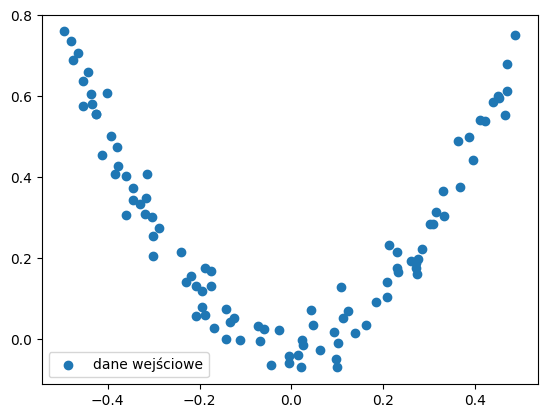

In [56]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

plt.scatter(X,y, label='dane wejściowe')
plt.legend()
plt.show()

Drzewa regresyjne wzmacniane gradientowo (ang. *gradient boosted regression trees* — GBRT)
- pierwsze drzewo w szeregu (z limitem głębokości ustalonym na 2):

In [57]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

,"criterion criterion: {""squared_error"", ""friedman_mse"", ""absolute_error"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in the half mean Poisson deviance to find splits... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 0.24 Poisson deviance criterion.",'squared_error'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.For an example of how ``max_depth`` influences the model, see:ref:`sphx_glr_auto_examples_tree_plot_tree_regression.py`.",2
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",None
,"max_le

- drugie drzewo zostaje dopasowane do błędów przewidywania popełnionych przez pierwsze drzewo:

In [58]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

,"criterion criterion: {""squared_error"", ""friedman_mse"", ""absolute_error"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in the half mean Poisson deviance to find splits... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 0.24 Poisson deviance criterion.",'squared_error'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.For an example of how ``max_depth`` influences the model, see:ref:`sphx_glr_auto_examples_tree_plot_tree_regression.py`.",2
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",None
,"max_le

- kolejne drzewo zostaje dopasowane do błędów resztowych popełnionych przez poprzedzające drzewo:

In [60]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

,"criterion criterion: {""squared_error"", ""friedman_mse"", ""absolute_error"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in the half mean Poisson deviance to find splits... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 0.24 Poisson deviance criterion.",'squared_error'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.For an example of how ``max_depth`` influences the model, see:ref:`sphx_glr_auto_examples_tree_plot_tree_regression.py`.",2
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",None
,"max_le

- Przykład będzie ograniczony do tylko tych 3 drzew.
- Nowe dane:

In [ ]:
X_new = np.array([[-0.4], [0.], [0.5]])

- Przewidywania dla nowych danych:

In [73]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.49484029, 0.04021166, 0.75026781])

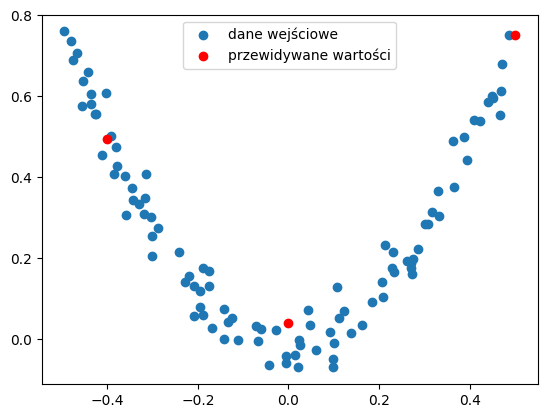

In [74]:
plt.scatter(X,y, label='dane wejściowe')
plt.scatter(X_new,y_pred, color='r', label='przewidywane wartości')
plt.legend()
plt.show()

- Przewidywania generowane przez kolejne predyktory (kod z książki):

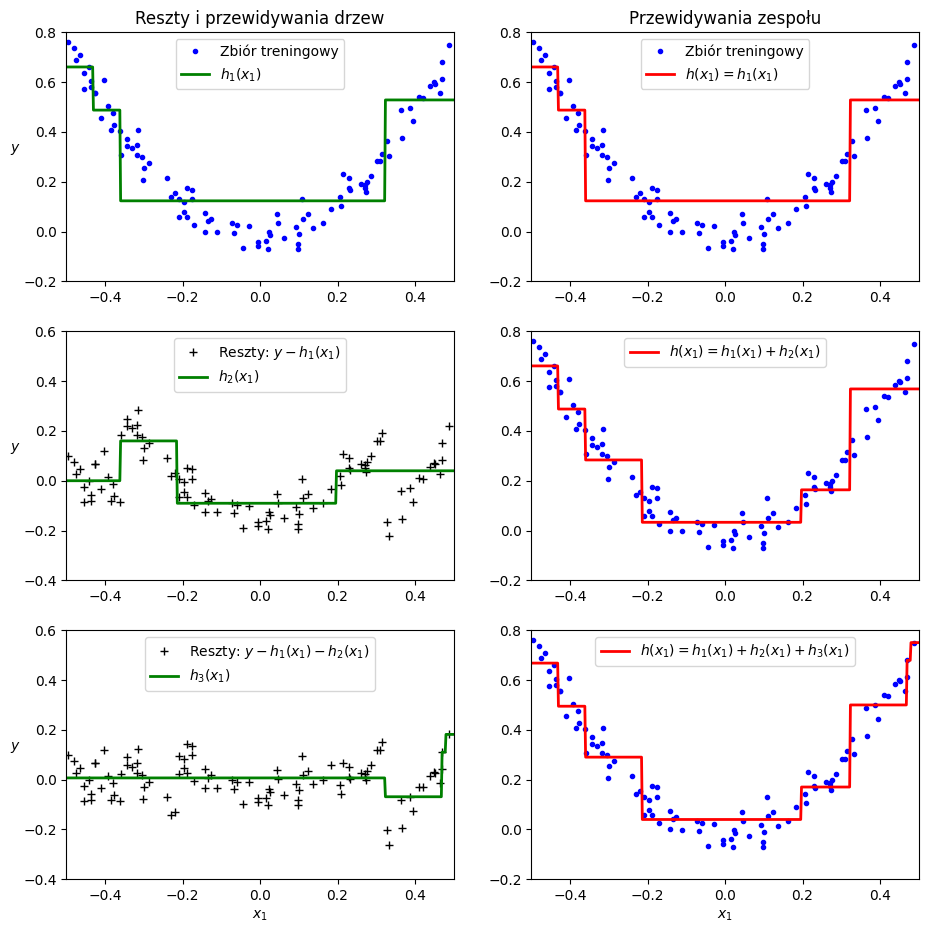

In [79]:
def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Zbiór treningowy")
plt.ylabel("$y$  ", rotation=0)
plt.title("Reszty i przewidywania drzew")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Zbiór treningowy")
plt.title("Przewidywania zespołu")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Reszty: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Reszty: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")
plt.show()



- Wykonanie powyższego regresora GBRT za pomocą `scikit-learn`:

In [80]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, 
                                 n_estimators=3,
                                 learning_rate=1.0, 
                                 random_state=42)
gbrt.fit(X, y)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",1.0
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",3
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",2
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft ch

In [81]:
y_pred = gbrt.predict(X_new)
y_pred

array([0.49484029, 0.04021166, 0.75026781])

- Hiperparametr **współczynnika uczenia** (*learning rate*) określa skalowanie wpływu każdego kolejnego drzewa.
- Dla wartości 1 każde kolejne drzewo ma taki sam wpływ.
- Wartości poniżej 1 powodują, że kolejne drzewa mają coraz mniejszy wpływ, co wprawdzie spowalnia trening i może wymagać większej liczby drzew, ale umożliwia stworzenie bardziej dokładnego modelu.